# 信用卡詐騙偵測：資料探索、模型建置與評估 （Decision Tree & SVM 範例）

**作者**：Pei Hsuan Lee  
**日期**：2025-07-29  
**專案簡介**：  
> 本範例使用 Kaggle 上的信用卡交易資料<a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Credit Card Fraud Detection</a>，演示從資料探索（EDA）、特徵工程，到決策樹與支援向量機（SVM）模型的訓練與評估流程，並分享我的實作心得與應用建議。

---

## 1. 環境與資料讀取


In [27]:
# 匯入套件
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # 僅用於繪圖設定
import numpy as np
import kagglehub
import os

%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier,  plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import LinearSVC, SVC

import warnings
warnings.filterwarnings('ignore')

# 指定中文字型，mac/linux/windows 可能不同
# plt.rcParams['font.sans-serif'] = ['SimHei']   # Windows 中文黑體
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Mac 推薦用
plt.rcParams['axes.unicode_minus'] = False     # 正常顯示負號


In [ ]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

csv_file = os.path.join(path, "creditcard.csv")
df = pd.read_csv(csv_file)
df.head()

Path to dataset files: /Users/hsuanlee/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. 資料探索 (Exploratory Data Analysis, EDA)

### 2.1 資料概況

In [17]:
df.shape

(284807, 31)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [19]:
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

- 資料筆數約 284,807 筆，特徵包含 V1–V28 以及 Amount、Time、Class  
- 正負樣本極度不平衡（詐騙約 0.17%）  

---

**個人心得：**  
> * 不平衡資料問題非常常見，後續需思考用 oversampling、under-sampling 或調整模型權重。  
>  
> * 先畫出 Class 的長條圖，直觀感受不平衡程度。

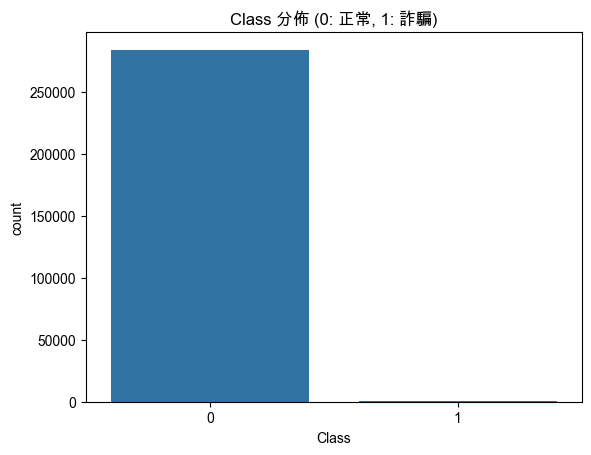

In [24]:
sns.countplot(x='Class', data=df)
plt.title('Class 分佈 (0: 正常, 1: 詐騙)')
plt.show()

### 2.2 特徵與目標相關性 (Correlation Analysis)

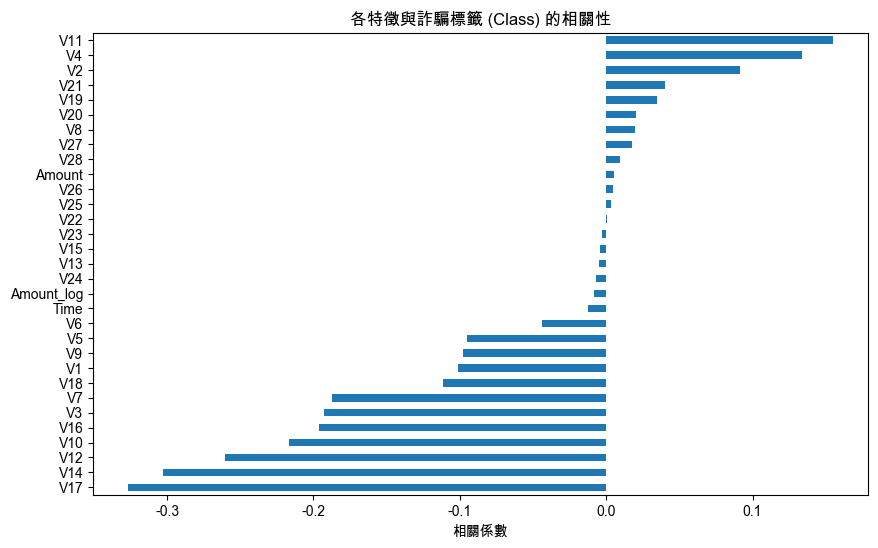

In [30]:
# 計算各特徵與 Class 的 Pearson 相關係數（不含自己）
correlation_values = df.corr()['Class'].drop('Class')

# 畫出水平長條圖
plt.figure(figsize=(10, 6))
correlation_values.sort_values().plot(kind='barh')
plt.title('各特徵與詐騙標籤 (Class) 的相關性')
plt.xlabel('相關係數')
plt.show()

> **Insights（觀察重點）：** 
>
> 1. 部分 V 特徵（如 V17、V14）與 Class 顯示較高的正相關／負相關，代表在區分詐騙樣本上比較有貢獻。
>
> 2. Amount_log 與 Class 的相關性較低，意即金額大小並非最強區分因素，可能要搭配其他特徵或衍生時間、地點等外部欄位。
>
> 3. 若要進一步篩選重要特徵，可考慮用 SelectKBest、Tree-based feature importance 等方法。
>
> 4. 觀察到多數 V 欄位相關性接近 0，說明這些主成分轉換過後的特徵分佈較為分散，對模型的差異化貢獻度不一。

## 3. 特徵工程與資料切分

In [31]:
# standardize features by removing the mean and scaling to unit variance
df.iloc[:, 1:30] = StandardScaler().fit_transform(df.iloc[:, 1:30])
data_matrix = df.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

> **個人小提醒：**
> 
> * 一定要用 stratify=y 保持切分後兩類比例一致。
>
> * 若資料量更大，可考慮再切出驗證集（validation）做超參數調整。

## 4. 模型一：決策樹 (Decision Tree)

> **💡 重點：**
>
> DecisionTreeClassifier 本身沒有自動處理不平衡資料的參數，需要你手動告訴它樣本權重。

In [36]:
w_train = compute_sample_weight('balanced', y_train)
w_train

array([0.50089444, 0.50089444, 0.50089444, ..., 0.50089444, 0.50089444,
       0.50089444])


**📝 w_train 是什麼？** 
w_train 是一個 樣本權重向量，長度等於你的訓練集樣本數，每個樣本都有一個對應的權重。


**💡 為什麼需要這個？**
因為：
訓練資料的類別分佈不均衡（class imbalance），容易讓模型偏向於樣本數量多的類別。
例如：
* 你有 1000 個樣本，其中 950 是類別 0，50 是類別 1。
* 如果不做處理，模型可能只學會永遠預測類別 0。

為了讓模型公平地對待兩個類別，我們給每個樣本一個權重：
* 讓少數類別的樣本權重大
* 讓多數類別的樣本權重小

這樣計算損失的時候，每個類別對總損失的貢獻會更平衡。

**⚖️ 權重怎麼算？**

當你用：compute_sample_weight("balanced", y_train)時，權重公式大致為：

$$
w_i = \frac{n_{\text{samples}}}{n_{\text{classes}} \cdot n_{y_i}}
$$

其中：
* nsamples → 總樣本數
* nclasses → 類別數
* nyi → yi 這個類別的樣本數
也就是說：
* 類別 0：有很多樣本 → 每個樣本權重小
* 類別 1：樣本少 → 每個樣本權重大

**🔷 如何用？**

你可以把這個權重傳給模型的 `fit()`：

`model.fit(X_train, y_train, sample_weight=w_train)`

💛這樣模型在計算損失時會考慮樣本權重，減少類別不平衡的影響。

In [35]:
# w0, w1
print("Weight for category 0:", y_train.shape[0] / (2 * y_train[y_train==0].shape[0]))
print("Weight for category 1:", y_train.shape[0] / (2 * y_train[y_train==1].shape[0]))

Weight for category 0: 0.5008944364045667
Weight for category 1: 280.0056179775281


In [34]:
# for reproducible output across multiple function calls, set random_state to a given integer value
dt = DecisionTreeClassifier(max_depth=4, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=4, random_state=35)

## 5. 模型二：支持向量機 (SVM)

In [37]:
# for reproducible output across multiple function calls, set random_state to a given integer value
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

> **📊 補充、筆記重點**
> - class_weight='balanced'：這個參數告訴模型在訓練的時候，自動計算每個類別的權重（根據類別頻率），並內部調整 loss function 來平衡。所以不需要額外傳 sample_weight。如果不用 class_weight='balanced'，對於極度不平衡的資料，模型可能只學會預測多數類別。
> - random_state: 隨機種子，用於結果可重現
> - loss: 使用 hinge loss（SVM 的經典損失函數，最大化間隔的線性分類器）
> - fit_intercept: 不額外學習偏置項 b，僅依賴特徵本身。如果你把 fit_intercept=True，模型會額外學一個偏移值b。

## 6. 模型評估(Phase I)

### 6.1 決策樹評估

In [38]:
y_pred_dt = dt.predict_proba(X_test)[:,1]

In [39]:
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.939


### 6.2 SVM模型評估

In [41]:
y_pred_svm = svm.decision_function(X_test)

In [42]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.986


### 6.3 模型比較結果

> 當使用所有特徵時，SVM表現比決策樹來的更好。

## 7. 特徵選擇

> 使用corr()函數篩選和目標變數相關性的Top6變數

In [45]:
# your code goes here
correlation_values = abs(df.corr()['Class']).drop('Class')
correlation_values = correlation_values.sort_values(ascending=False)[:6]
correlation_values

V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
Name: Class, dtype: float64

In [46]:
# your code goes here
X = data_matrix[:,[3,10,12,14,16,17]]

### 比較篩選變數後模型表現

In [47]:
# Data Preprocessing
df.iloc[:, 1:30] = StandardScaler().fit_transform(df.iloc[:, 1:30])
data_matrix = df.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
# X = data_matrix[:, 1:30]
X = data_matrix[:,[3,10,12,14,16,17]]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")


# Dataset Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build models
w_train = compute_sample_weight('balanced', y_train)
dt = DecisionTreeClassifier(max_depth=4, random_state=35)
dt.fit(X_train, y_train, sample_weight=w_train)

svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
svm.fit(X_train, y_train)

# Evaluate model performances
y_pred_dt = dt.predict_proba(X_test)[:,1]
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

y_pred_svm = svm.decision_function(X_test)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

Decision Tree ROC-AUC score : 0.952
SVM ROC-AUC score: 0.937


#### 📊重點筆記
SVM
- 在特徵數量較多的情況下，SVM 相較於決策樹表現得更好。(特徵多時AUC: 0.986 -> 特徵變少時AUC: 0.937)
- SVM 是一種基於「邊界」的模型（決策超平面），通常在 高維度空間中會有更多彈性來找到區分兩類的最佳超平面。
- 降維後，資訊變少，SVM 可能無法找到一條能很好分開正負樣本的界線。
- 換句話說，SVM 常常「吃維度」，維度高反而更有利。
- SVM可能需要更高維度的特徵空間，才能構建出有效的決策超平面。
 
決策樹
- 決策樹從特徵選擇中獲益，表現更佳。(特徵多時AUC: 0.939 -> 特徵變少時AUC: 0.952)
- 決策樹對「無關特徵」很敏感，容易在早期分裂中被不重要的特徵「誤導」。
- 節點分裂若基於雜訊特徵，會導致 模型複雜但沒學到真正的規律。
- 只保留高關聯的 6 個特徵後，模型能更清楚抓住對分類真正有幫助的訊號 → 更乾淨的分裂規則，更穩定、更準確。


#### 簡單結論
- 決策樹：喜歡乾淨、有關聯的少量特徵，去除雜訊有幫助
- SVM：需要高維空間來找到最佳決策邊界，特徵太少可能反而限制模型能力